In [1]:

#Ejecutar si es la primera vez o se ha reiniciado el entorno de ejecucion
# Instalar Java y PySpark
!apt-get install openjdk-11-jdk -y
!pip install pyspark

# Configurar variables de entorno
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["PATH"] += os.pathsep + os.path.join(os.environ["JAVA_HOME"], "bin")

# Verificar instalación
!java -version
!python -m pip show pyspark



Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  ca-certificates-java fonts-dejavu-core fonts-dejavu-extra java-common
  libatk-wrapper-java libatk-wrapper-java-jni libpcsclite1 libxt-dev libxtst6
  libxxf86dga1 openjdk-11-jdk-headless openjdk-11-jre openjdk-11-jre-headless
  x11-utils
Suggested packages:
  default-jre pcscd libxt-doc openjdk-11-demo openjdk-11-source visualvm
  libnss-mdns fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  | fonts-wqy-zenhei fonts-indic mesa-utils
The following NEW packages will be installed:
  ca-certificates-java fonts-dejavu-core fonts-dejavu-extra java-common
  libatk-wrapper-java libatk-wrapper-java-jni libpcsclite1 libxt-dev libxtst6
  libxxf86dga1 openjdk-11-jdk openjdk-11-jdk-headless openjdk-11-jre
  openjdk-11-jre-headless x11-utils
0 upgraded, 15 newly installed, 0 to remove and 41 not upgraded.
Need to get 122 MB of archives.


In [2]:
import kagglehub
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [3]:
path = kagglehub.dataset_download("fedesoriano/heart-failure-prediction")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'heart-failure-prediction' dataset.
Path to dataset files: /kaggle/input/heart-failure-prediction


In [4]:
spark = SparkSession.builder.appName("DataAnalysis").getOrCreate()
df = spark.read.csv(path, header=True, inferSchema=True)


Analisis descriptivo



In [5]:
df.printSchema()
df.show(20, truncate=False)

print(f"Total filas del df: {df.count()}")

root
 |-- Age: integer (nullable = true)
 |-- Sex: string (nullable = true)
 |-- ChestPainType: string (nullable = true)
 |-- RestingBP: integer (nullable = true)
 |-- Cholesterol: integer (nullable = true)
 |-- FastingBS: integer (nullable = true)
 |-- RestingECG: string (nullable = true)
 |-- MaxHR: integer (nullable = true)
 |-- ExerciseAngina: string (nullable = true)
 |-- Oldpeak: double (nullable = true)
 |-- ST_Slope: string (nullable = true)
 |-- HeartDisease: integer (nullable = true)

+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
|Age|Sex|ChestPainType|RestingBP|Cholesterol|FastingBS|RestingECG|MaxHR|ExerciseAngina|Oldpeak|ST_Slope|HeartDisease|
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
|40 |M  |ATA          |140      |289        |0        |Normal    |172  |N             |0.0    |Up      |0           |
|49 |F  |NAP          |160  

In [6]:
df.describe().show()

+-------+------------------+----+-------------+------------------+------------------+-------------------+----------+------------------+--------------+------------------+--------+-------------------+
|summary|               Age| Sex|ChestPainType|         RestingBP|       Cholesterol|          FastingBS|RestingECG|             MaxHR|ExerciseAngina|           Oldpeak|ST_Slope|       HeartDisease|
+-------+------------------+----+-------------+------------------+------------------+-------------------+----------+------------------+--------------+------------------+--------+-------------------+
|  count|               918| 918|          918|               918|               918|                918|       918|               918|           918|               918|     918|                918|
|   mean|53.510893246187365|NULL|         NULL|132.39651416122004| 198.7995642701525|0.23311546840958605|      NULL|136.80936819172112|          NULL|0.8873638344226581|    NULL| 0.5533769063180828|
| std

Valores nulos

In [10]:
df.select([F.sum(F.when(F.col(c).isNull(), 1).otherwise(0)).alias(c) for c in df.columns]).show()

+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
|Age|Sex|ChestPainType|RestingBP|Cholesterol|FastingBS|RestingECG|MaxHR|ExerciseAngina|Oldpeak|ST_Slope|HeartDisease|
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
|  0|  0|            0|        0|          0|        0|         0|    0|             0|      0|       0|           0|
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+



Eliminación de valores duplicados

In [11]:
df = df.dropDuplicates()
print(f"Total filas del df: {df.count()}")

Total filas del df: 918


Separamos los valores numericos y categoricos



In [12]:
df_numericos = df.select("Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak")
df_categoricos = df.select("Sex", "ChestPainType", "FastingBS", "RestingECG", "ExerciseAngina", "ST_Slope", "HeartDisease")
#Lo pasamos a pandas para hacer las graficas
df_numericos = df_numericos.toPandas()
df_categoricos = df_categoricos.toPandas()

Analisis Univariante



Analisis univariante de valores numericos



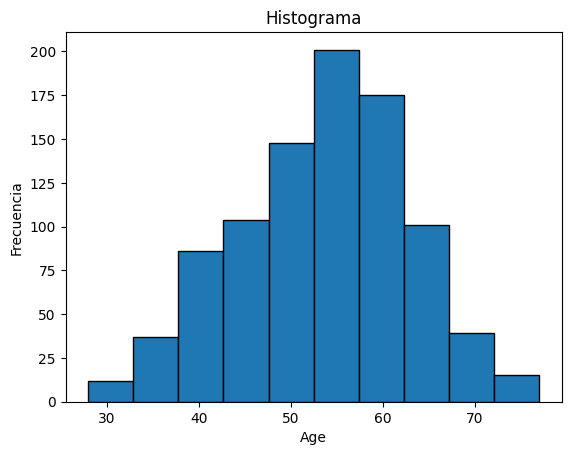

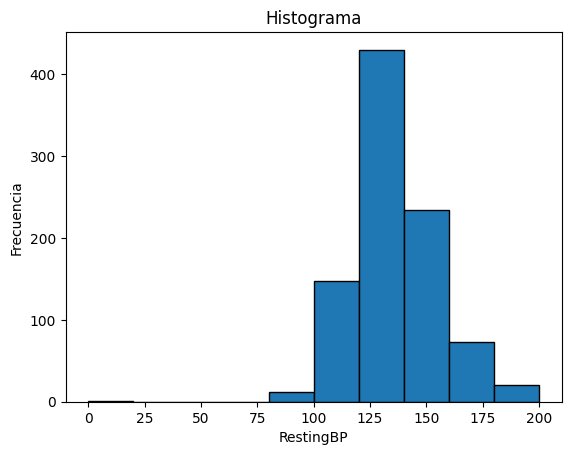

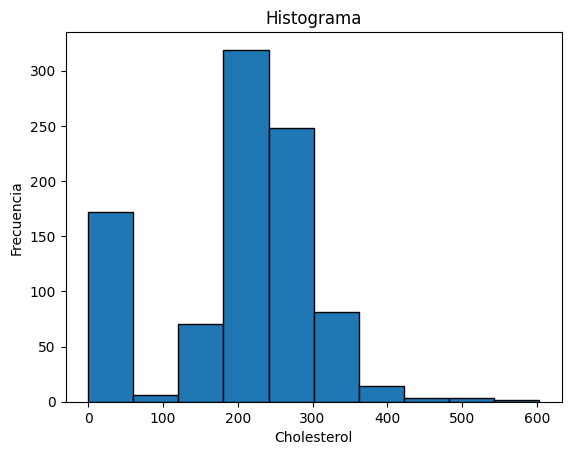

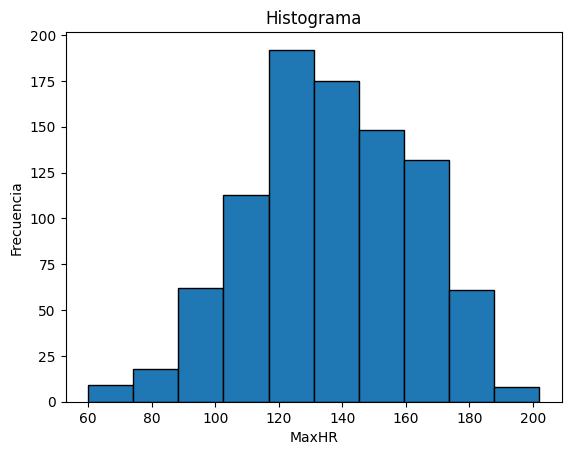

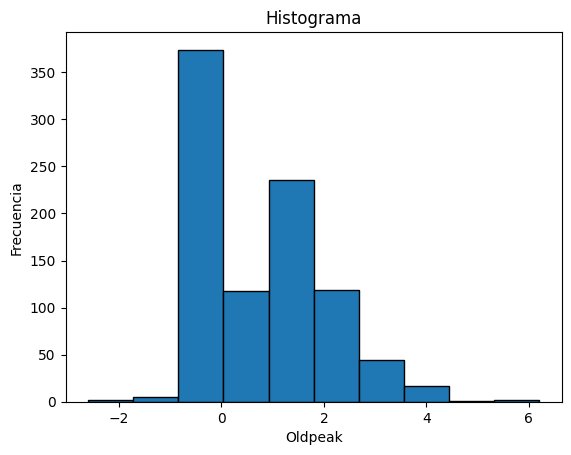

In [13]:
for i in df_numericos:
  plt.hist(df_numericos[i], edgecolor='black')
  plt.title('Histograma')
  plt.xlabel(i)
  plt.ylabel('Frecuencia')
  plt.show()
  print()

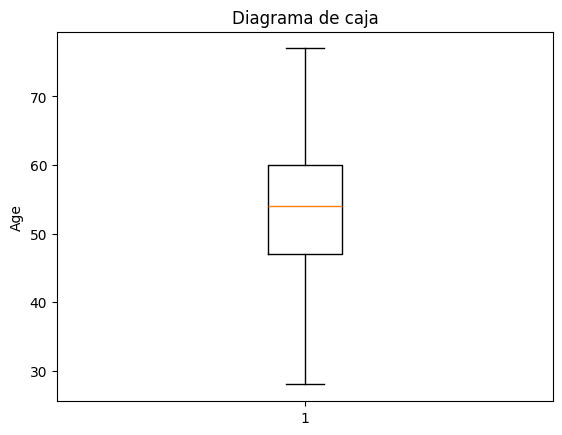

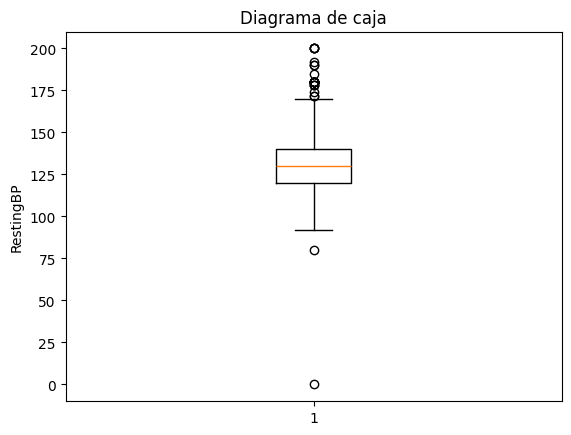

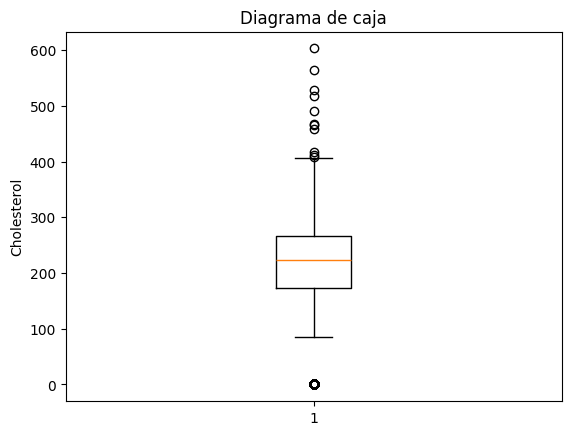

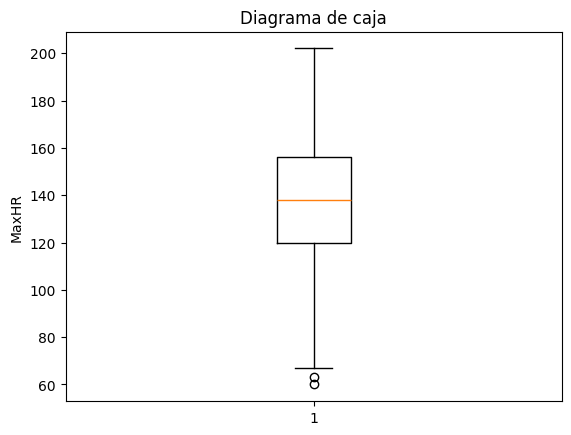

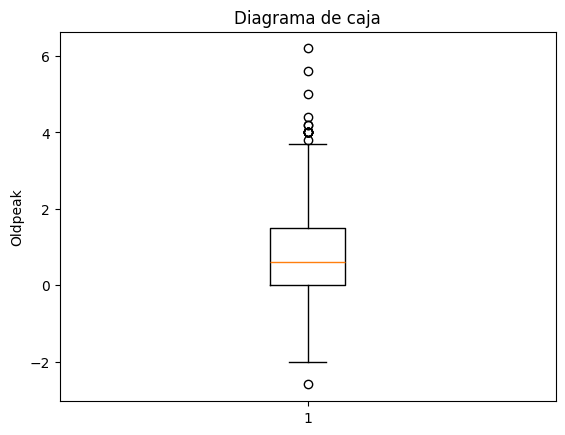

In [14]:
for i in df_numericos:
    plt.boxplot(df_numericos[i])
    plt.title('Diagrama de caja')
    plt.ylabel(i)
    plt.show()
    print()

Analisis univariante de valores categoricos



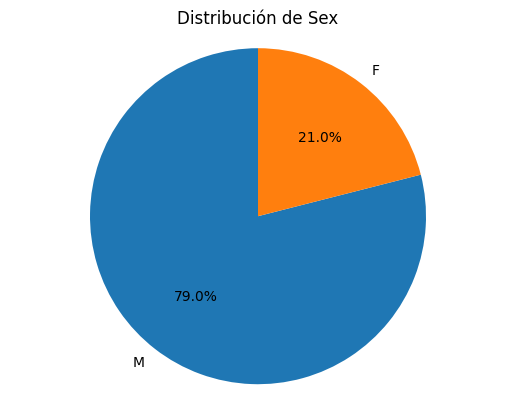

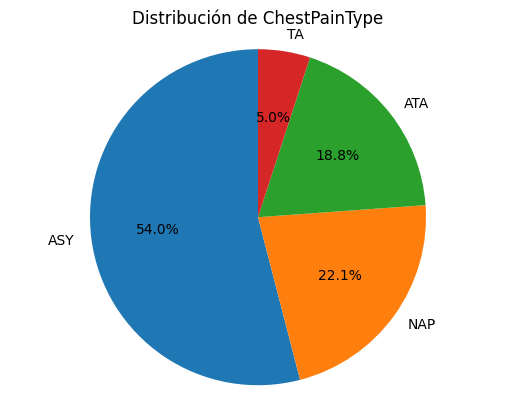

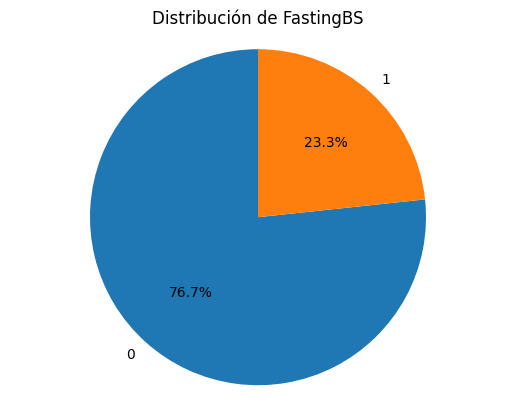

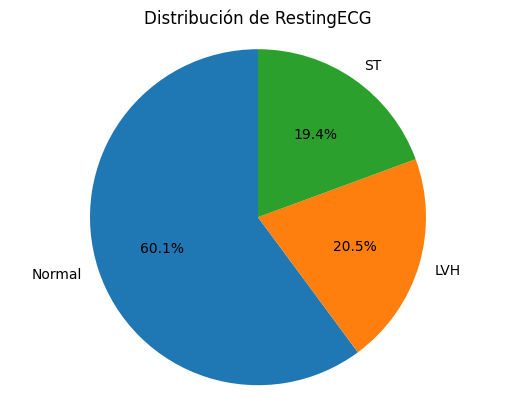

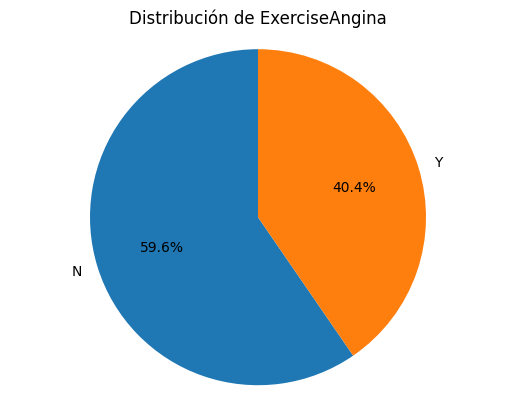

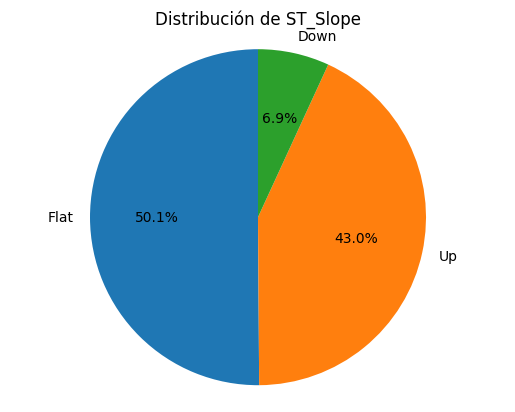

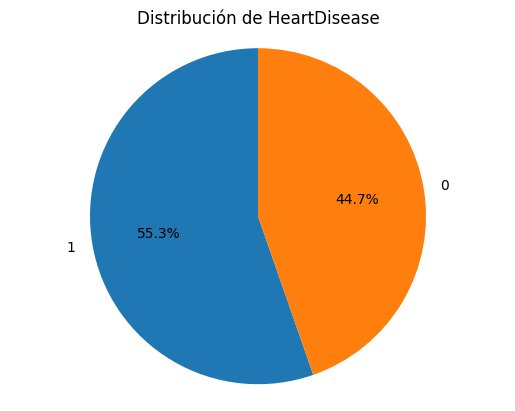

In [15]:
for i in df_categoricos:
    value_counts = df_categoricos[i].value_counts()
    plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90)
    plt.title('Distribución de ' + i)
    plt.axis('equal')
    plt.show()
    print()

Analisis bivariante entre numerica y numerica



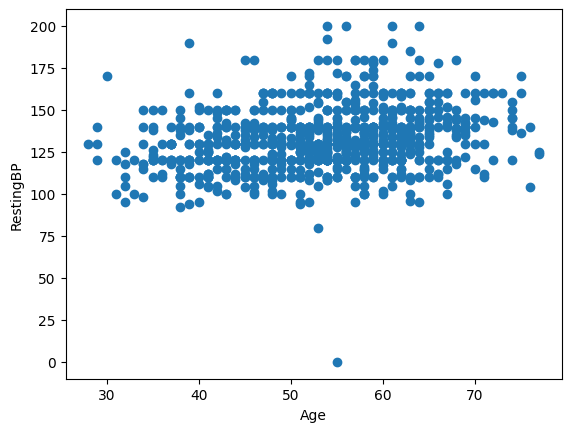

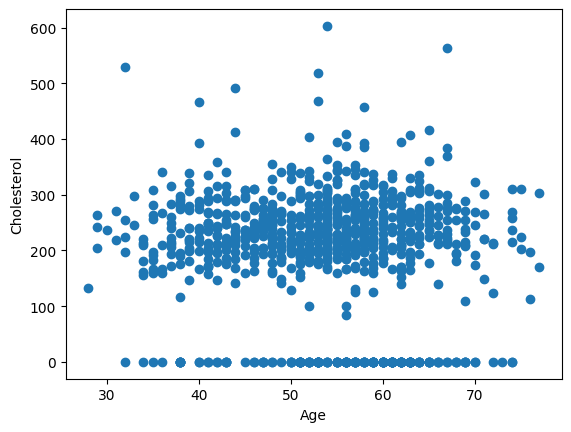

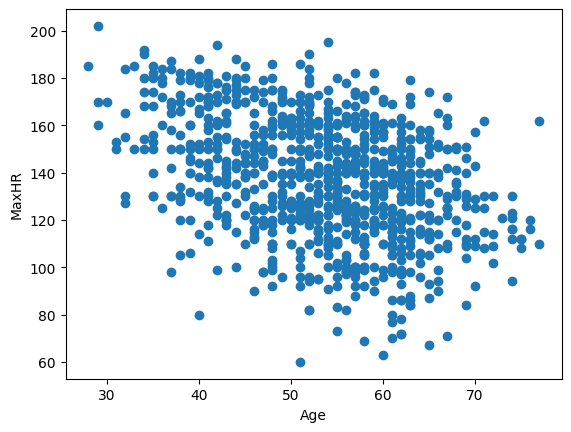

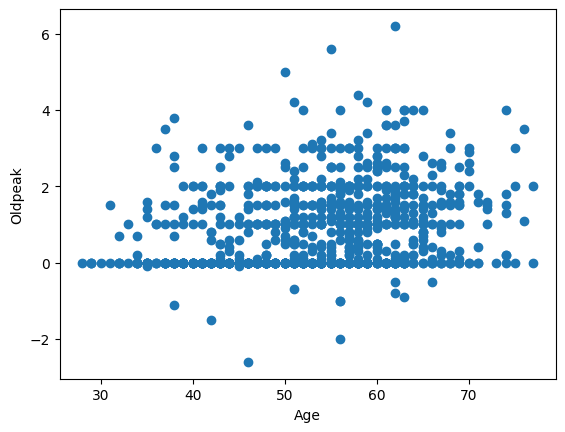

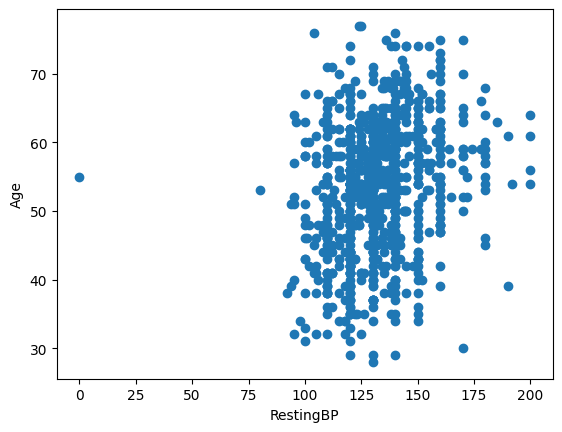

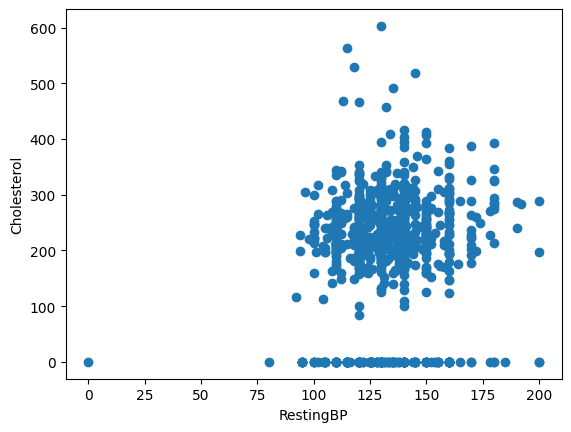

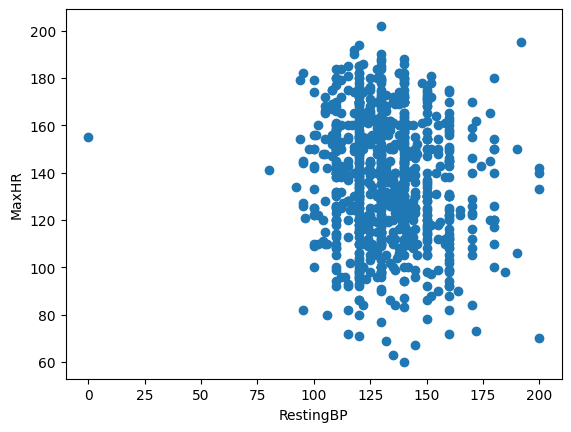

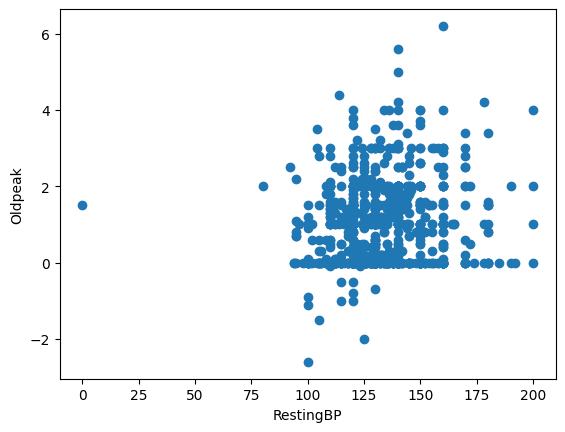

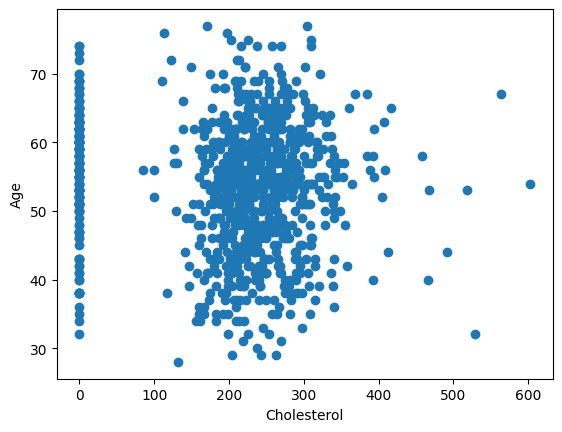

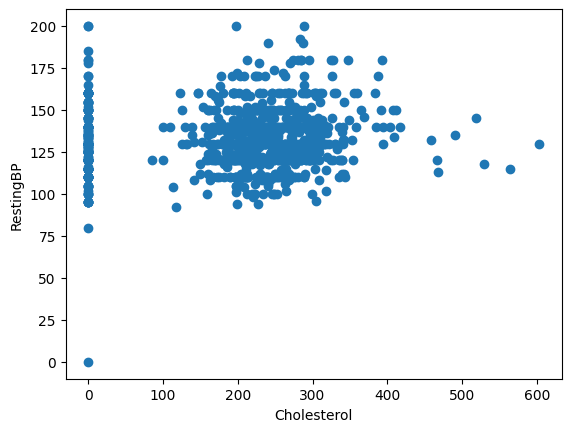

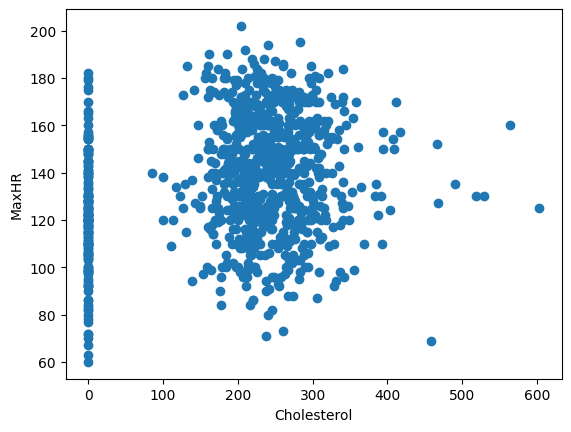

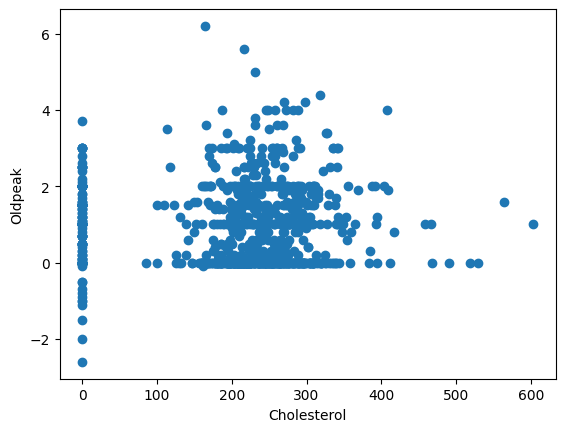

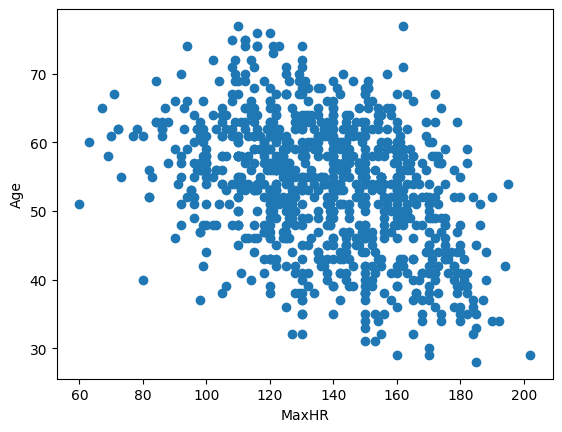

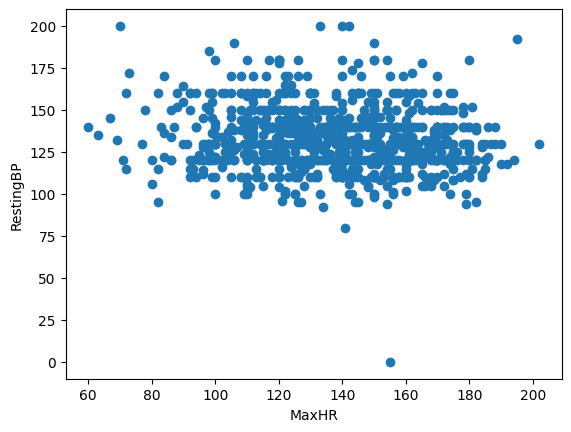

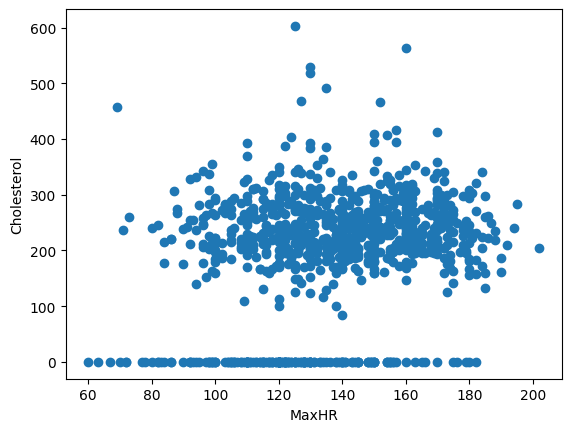

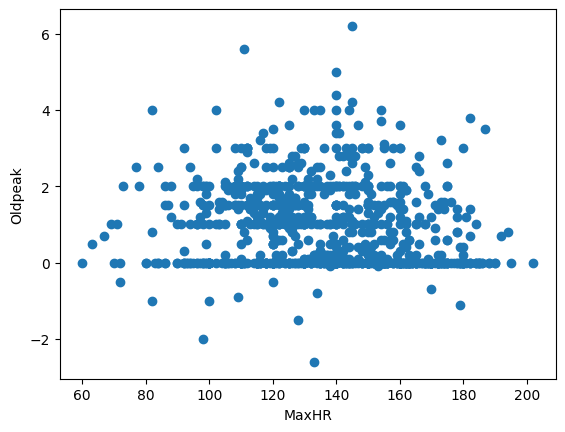

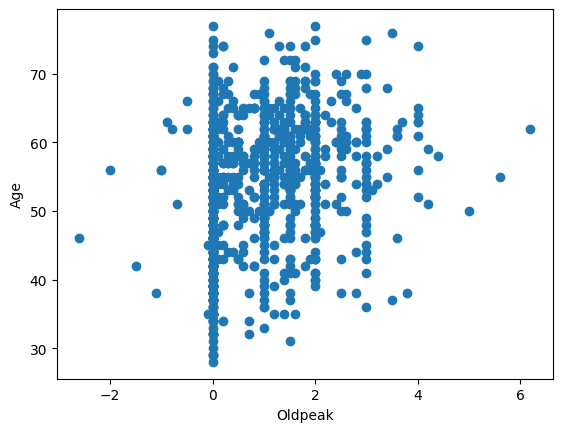

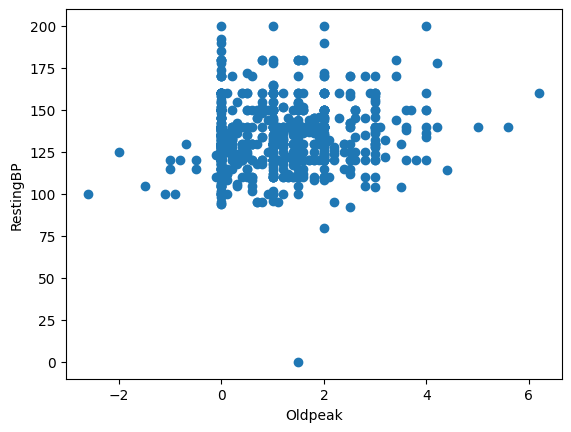

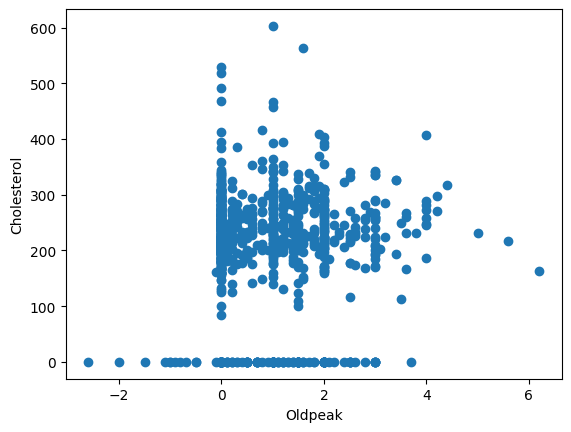

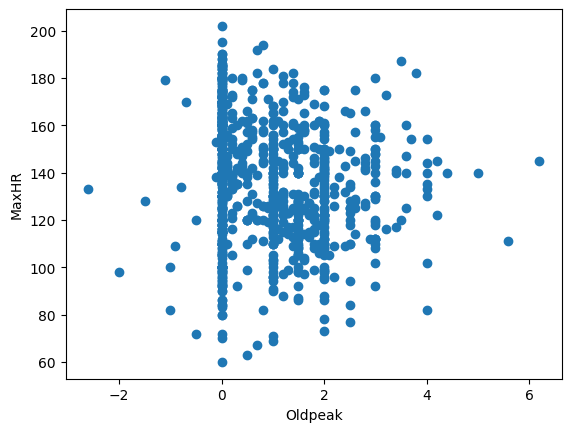

In [16]:
for i in df_numericos.columns:
  for j in df_numericos.columns:
    if i != j:
      plt.scatter(df_numericos[i], df_numericos[j])
      plt.xlabel(i)
      plt.ylabel(j)
      plt.show()
      print()

Analisis correlacion



In [17]:
df_numericos.corr()

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak
Age,1.000000,0.254399,-0.095282,-0.382045,0.258612
RestingBP,0.254399,1.000000,0.100893,-0.112135,0.164803
Cholesterol,-0.095282,0.100893,1.000000,0.235792,0.050148
MaxHR,-0.382045,-0.112135,0.235792,1.000000,-0.160691
Oldpeak,0.258612,0.164803,0.050148,-0.160691,1.000000


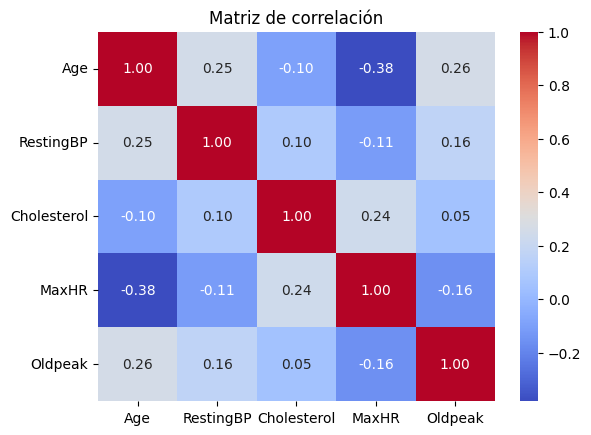

In [18]:
correlation_matrix = df_numericos.corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de correlación")
plt.show()

Limpieza de datos (sifuera necesario)

Transformacion de datos




In [19]:
df.show(5,0)

+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
|Age|Sex|ChestPainType|RestingBP|Cholesterol|FastingBS|RestingECG|MaxHR|ExerciseAngina|Oldpeak|ST_Slope|HeartDisease|
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
|58 |M  |ASY          |128      |216        |0        |LVH       |131  |Y             |2.2    |Flat    |1           |
|41 |M  |ASY          |130      |172        |0        |ST        |130  |N             |2.0    |Flat    |1           |
|59 |M  |NAP          |130      |318        |0        |Normal    |120  |Y             |1.0    |Flat    |0           |
|44 |M  |ASY          |135      |491        |0        |Normal    |135  |N             |0.0    |Flat    |1           |
|51 |F  |NAP          |150      |200        |0        |Normal    |120  |N             |0.5    |Up      |0           |
+---+---+-------------+---------+-----------+---------+-

Mapeamos las columnas categóricas a valores numéricos para que el modelo pueda entenderlos:
*   Sex: M = 0 , F = 1
*   ChestPainType: ATA = 0 , NAP = 1 , ASY = 2 , TA = 3
*   RestingECG: Normal = 0 , ST = 1 , LVH = 2
*   ExerciseAngina: N = 0 , Y = 1
*   Elemento de lista: Up  0 , Flat = 1, Down = 2

In [20]:
df = df.withColumn("Sex", F.when(F.col("Sex") == "M", 0).otherwise(1)) \
.withColumn("ChestPainType", F.when(F.col("ChestPainType") == "ATA", 0)
                            .when(F.col("ChestPainType") == "NAP", 1)
                            .when(F.col("ChestPainType") == "ASY", 2)
                            .otherwise(3)) \
.withColumn("RestingECG", F.when(F.col("RestingECG") == "Normal", 0)
                            .when(F.col("RestingECG") == "ST", 1)
                            .otherwise(2)) \
.withColumn("ExerciseAngina", F.when(F.col("ExerciseAngina") == "N", 0).otherwise(1)) \
.withColumn("ST_Slope", F.when(F.col("ST_Slope") == "Up", 0)
                            .when(F.col("ST_Slope") == "Flat", 1)
                            .otherwise(2))

In [21]:
df.show(5,0)

+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
|Age|Sex|ChestPainType|RestingBP|Cholesterol|FastingBS|RestingECG|MaxHR|ExerciseAngina|Oldpeak|ST_Slope|HeartDisease|
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
|58 |0  |2            |128      |216        |0        |2         |131  |1             |2.2    |1       |1           |
|41 |0  |2            |130      |172        |0        |1         |130  |0             |2.0    |1       |1           |
|59 |0  |1            |130      |318        |0        |0         |120  |1             |1.0    |1       |0           |
|44 |0  |2            |135      |491        |0        |0         |135  |0             |0.0    |1       |1           |
|51 |1  |1            |150      |200        |0        |0         |120  |0             |0.5    |0       |0           |
+---+---+-------------+---------+-----------+---------+-

Normalizacion

In [22]:
df_numericos = df.select("Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak")
df_numericos = df_numericos.toPandas()

scaler = MinMaxScaler()
df_numericos_scaled = pd.DataFrame(scaler.fit_transform(df_numericos), columns=df_numericos.columns)

In [23]:
df_numericos_norm = spark.createDataFrame(df_numericos_scaled)
df_numericos_norm.show(5,0)

+-------------------+---------+-------------------+-------------------+-------------------+
|Age                |RestingBP|Cholesterol        |MaxHR              |Oldpeak            |
+-------------------+---------+-------------------+-------------------+-------------------+
|0.6122448979591837 |0.64     |0.35820895522388063|0.5                |0.5454545454545454 |
|0.26530612244897955|0.65     |0.285240464344942  |0.49295774647887325|0.5227272727272727 |
|0.6326530612244898 |0.65     |0.527363184079602  |0.4225352112676056 |0.4090909090909091 |
|0.3265306122448979 |0.675    |0.8142620232172472 |0.5281690140845071 |0.29545454545454547|
|0.46938775510204067|0.75     |0.33167495854063017|0.4225352112676056 |0.3522727272727273 |
+-------------------+---------+-------------------+-------------------+-------------------+
only showing top 5 rows



In [24]:


df = df.withColumn("row_id", F.monotonically_increasing_id())
df_numericos_norm = df_numericos_norm.withColumn("row_id", F.monotonically_increasing_id())

df = df.drop("Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak")

df = df.join(df_numericos_norm, on="row_id", how="inner").drop("row_id")

df_resultado_final = df.select("Age","Sex","ChestPainType","RestingBP","Cholesterol","FastingBS","RestingECG","MaxHR","ExerciseAngina","Oldpeak","ST_Slope","HeartDisease")

df_resultado_final.show(5,0)


+-------------------+---+-------------+---------+-------------------+---------+----------+-------------------+--------------+-------------------+--------+------------+
|Age                |Sex|ChestPainType|RestingBP|Cholesterol        |FastingBS|RestingECG|MaxHR              |ExerciseAngina|Oldpeak            |ST_Slope|HeartDisease|
+-------------------+---+-------------+---------+-------------------+---------+----------+-------------------+--------------+-------------------+--------+------------+
|0.6122448979591837 |0  |2            |0.64     |0.35820895522388063|0        |2         |0.5                |1             |0.5454545454545454 |1       |1           |
|0.26530612244897955|0  |2            |0.65     |0.285240464344942  |0        |1         |0.49295774647887325|0             |0.5227272727272727 |1       |1           |
|0.6326530612244898 |0  |1            |0.65     |0.527363184079602  |0        |0         |0.4225352112676056 |1             |0.4090909090909091 |1       |0     

Guardamos los datos limpiados y transformados en un nuevo csv


*   Escritura en spark (ideal si siguieramos en spark)
*   Escritura en pandas (ideal para el entrenamiento)




In [25]:
df_resultado_final.write.csv("Datos para entrenamiento_spark.csv", header=True, mode="overwrite")

In [26]:
df_resultado_final_pandas = df_resultado_final.toPandas()
df_resultado_final_pandas.to_csv("Datos para entrenamiento_pandas.csv", header=True)